In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from joblib import dump, load
import matplotlib.pyplot as plt

In [2]:
train_dir = "Dataset/Training"
validation_dir = "Dataset/Validation"
test_dir = "Dataset/Testing"

In [3]:
img_height = 300
img_width = 300
batch_size = 16

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


Found 34 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


In [5]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze layers in the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
finetune_model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
# Compile the model
finetune_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10)
def schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)
lr_schedule = LearningRateScheduler(schedule)

In [7]:
history = finetune_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stop, lr_schedule])

# Save the model weights
#finetune_model.save_weights("Final_model.h5")

Epoch 1/50
2/2 [==============================] - 7s 1s/step - loss: 0.8271 - accuracy: 0.4688 - lr: 1.0000e-04
Epoch 2/50
2/2 [==============================] - 1s 1s/step - loss: 0.9191 - accuracy: 0.5556 - lr: 1.0000e-04
Epoch 3/50
2/2 [==============================] - 1s 1s/step - loss: 0.6478 - accuracy: 0.6111 - lr: 1.0000e-04
Epoch 4/50
2/2 [==============================] - 1s 170ms/step - loss: 0.6183 - accuracy: 0.6111 - lr: 1.0000e-04
Epoch 5/50
2/2 [==============================] - 1s 1s/step - loss: 0.4489 - accuracy: 0.8333 - lr: 1.0000e-04
Epoch 6/50
2/2 [==============================] - 1s 1s/step - loss: 0.5280 - accuracy: 0.7778 - lr: 1.0000e-04
Epoch 7/50
2/2 [==============================] - 1s 183ms/step - loss: 0.5519 - accuracy: 0.7778 - lr: 1.0000e-04
Epoch 8/50
2/2 [==============================] - 2s 932ms/step - loss: 0.6910 - accuracy: 0.7500 - lr: 1.0000e-04
Epoch 9/50
2/2 [==============================] - 1s 183ms/step - loss: 0.4122 - accuracy: 0.88

Real


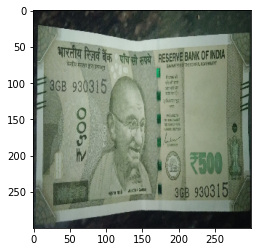

In [8]:
from tensorflow.keras.preprocessing.image import load_img

test_img = load_img("Dataset/Testing/Real.jpg", target_size=(img_height, img_width))
plt.imshow(test_img)
test_img = np.expand_dims(test_img, axis=0) / 255.0
output = finetune_model.predict(test_img)
if output[0][0] > output[0][1]:
    print("Fake")
else:
    print("Real")

In [12]:
dump(finetune_model, 'finalized_model.joblib', compress=True)

INFO:tensorflow:Assets written to: ram://b610c807-8441-46a6-aa73-b78af6274add/assets


['finalized_model.joblib']